In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
from loguru import logger
from ccp import construct_stat_arb
from utils import *

In [2]:
set_logger(logger, ['INFO', 'WARNING'], './logs')

In [3]:
keys = ['date', 'symbol']
start_date = datetime(2000, 1, 1)

In [4]:
%%time
prices_full = (
    pl.scan_parquet('prices_yf.parquet')
    .filter(pl.col(keys[0]) >= start_date)
    .collect()
    .pivot(index=keys[0], columns=keys[1], values='price')
    .to_pandas()
    .set_index('date')
)
assert prices_full.index.is_monotonic_increasing
prices_full.describe()

CPU times: user 9.15 s, sys: 3.01 s, total: 12.2 s
Wall time: 4.67 s


,AAME,AAON,AAPL,ABCB,ABEO,ABIO,ACGL,ACHC,ACHV,ACIW,...,ETEC,HKIT,SFWL,SYT,HOVR,SHLT,ISPR,MGIH,ARBB,IBOT
count,6104.000000,6104.000000,6104.000000,6105.000000,6105.000000,6.105000e+03,6105.000000,6105.000000,6105.000000,6105.000000,...,256.000000,257.000000,256.000000,257.000000,256.000000,256.000000,255.000000,254.000000,254.000000,252.000000
mean,2.528477,15.210332,36.113399,21.525251,6485.859902,1.242328e+05,19.772233,27.613114,60340.989466,15.572614,...,23.200551,5.046812,6.766961,5.481374,8.428488,9.217012,9.389463,1.673339,2.137890,37.980534
std,0.914201,17.780260,52.757266,14.670944,10809.846474,3.933655e+05,18.940727,25.238408,80762.945431,10.155245,...,2.049582,6.121816,4.199518,1.615841,3.554724,2.019101,1.599759,0.387567,1.052588,2.949540
min,0.406846,0.655093,0.198346,3.106778,2.250000,1.580000e+00,1.270833,0.500000,2.020000,1.666667,...,19.719999,0.569000,1.500000,2.730000,1.150000,5.730000,5.820000,0.950000,0.807000,32.569000
25%,1.850000,2.291461,1.895854,8.898570,112.000000,1.350000e+01,6.011111,5.480000,264.000000,6.413333,...,21.575000,1.320000,2.520000,3.840000,8.000000,7.980000,8.490000,1.378750,1.300000,35.521000
50%,2.486279,5.434194,12.924065,16.280764,1100.000000,7.484400e+02,12.413333,13.890000,21560.000000,13.103333,...,22.845000,2.330000,5.925000,6.240000,10.410000,9.147500,9.360000,1.770000,1.806500,37.684999
75%,3.199393,23.017581,40.612614,33.996368,6250.000000,8.935920e+04,29.650000,46.689999,111672.000000,23.219999,...,25.004999,6.184000,10.390000,6.980000,10.552000,10.700000,10.015000,1.910000,2.942500,39.667250
max,6.388604,92.879997,197.857529,56.184540,79501.320312,5.726700e+06,94.900002,89.059998,398475.000000,43.099998,...,27.375999,34.000000,16.790001,7.850000,10.920000,21.299999,16.299999,3.210000,4.650000,44.599998


In [5]:
P_max = 100
spread_max = 1
moving_mean = True
solver = 'CLARABEL'

args = {
    'prices': None,
    'P_max': P_max,
    'spread_max': spread_max,
    'moving_mean': moving_mean,
    # 's_init': None,  # set to default
    # 'mu_init': None,  # set to default
    # 'seed': None,  # changed
    # 'M': None,  # not used at all!
    'solver': solver,  # default value
    # 'second_pass': False,  # set to default
    'logger': logger,
}

def change_seed(seed):
    return construct_stat_arb(seed=seed, **args)

def fit_multi(formation, seeds):
    args['prices'] = formation
    return loop_finite(change_seed, seeds, processes, with_ray=False)

def fit_n_trade(formation, trading, seeds, t_max):
    stat_arbs = fit_multi(formation, seeds)
    return trade_multi(stat_arbs, formation, trading, t_max)

processes = 8
n_iters = 10  # TODO:change
K = 10

seeds_all = [
    [np.random.randint(9999) for _ in range(K)]
    for _ in range(n_iters)
]

t_max = 125
exit_length = 21  # hard coded parameter in ccp.Stat_Arb.get_q

n_stocks = 10

In [6]:
CUT = '2020-01-03'
formation = prices_full[:CUT].iloc[:, :n_stocks]
trading = prices_full[CUT:].iloc[:, :n_stocks].iloc[1:]

In [7]:
%%time
stat_arbs = fit_multi(formation, seeds_all[0])

CPU times: user 27.8 ms, sys: 127 ms, total: 155 ms
Wall time: 17.1 s


In [8]:
%%time
n_nulls, weights = fit_n_trade(formation, trading, seeds_all[0], t_max)

CPU times: user 287 ms, sys: 966 ms, total: 1.25 s
Wall time: 18 s


In [9]:
print(weights['attempt'].nunique())
weights = weights.query('attempt == 1').drop(columns='attempt')

10


In [10]:
print(n_nulls)
assert t_max + exit_length >= len(weights[weights.abs().ge(1e-5).any(axis=1)])
weights = weights.iloc[:t_max + exit_length, :]
weights

0


,AAME,AAPL,ABCB,ACGL,ACIW,ACHV,AAON,ACHC
date,,,,,,,,
2020-01-06,-0.849430,-0.054104,0.106362,-0.139276,-0.119886,6.180841e-06,NaN,NaN
2020-01-07,-0.662816,-0.042217,0.082995,-0.108678,-0.093548,4.822946e-06,NaN,NaN
2020-01-08,-0.679971,-0.043310,0.085143,-0.111491,-0.095969,4.947779e-06,NaN,NaN
2020-01-09,-0.866093,-0.055165,0.108448,-0.142008,-0.122238,6.302083e-06,NaN,NaN
2020-01-10,-0.940976,-0.059935,0.117825,-0.154286,-0.132807,6.846966e-06,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-07-28,-0.008587,-0.000547,0.001075,-0.001408,-0.001212,6.248598e-08,NaN,NaN
2020-07-29,-0.037974,-0.002419,0.004755,-0.006226,-0.005360,2.763150e-07,NaN,NaN
2020-07-30,-0.023208,-0.001478,0.002906,-0.003805,-0.003275,1.688710e-07,NaN,NaN


In [11]:
weights[weights.abs().ge(1e-5).any(axis=1)]

,AAME,AAPL,ABCB,ACGL,ACIW,ACHV,AAON,ACHC
date,,,,,,,,
2020-01-06,-0.849430,-0.054104,0.106362,-0.139276,-0.119886,6.180841e-06,NaN,NaN
2020-01-07,-0.662816,-0.042217,0.082995,-0.108678,-0.093548,4.822946e-06,NaN,NaN
2020-01-08,-0.679971,-0.043310,0.085143,-0.111491,-0.095969,4.947779e-06,NaN,NaN
2020-01-09,-0.866093,-0.055165,0.108448,-0.142008,-0.122238,6.302083e-06,NaN,NaN
2020-01-10,-0.940976,-0.059935,0.117825,-0.154286,-0.132807,6.846966e-06,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-07-24,-0.072338,-0.004608,0.009058,-0.011861,-0.010210,5.263656e-07,NaN,NaN
2020-07-27,-0.072339,-0.004608,0.009058,-0.011861,-0.010210,5.263742e-07,NaN,NaN
2020-07-28,-0.008587,-0.000547,0.001075,-0.001408,-0.001212,6.248598e-08,NaN,NaN


<Figure size 900x500 with 0 Axes>

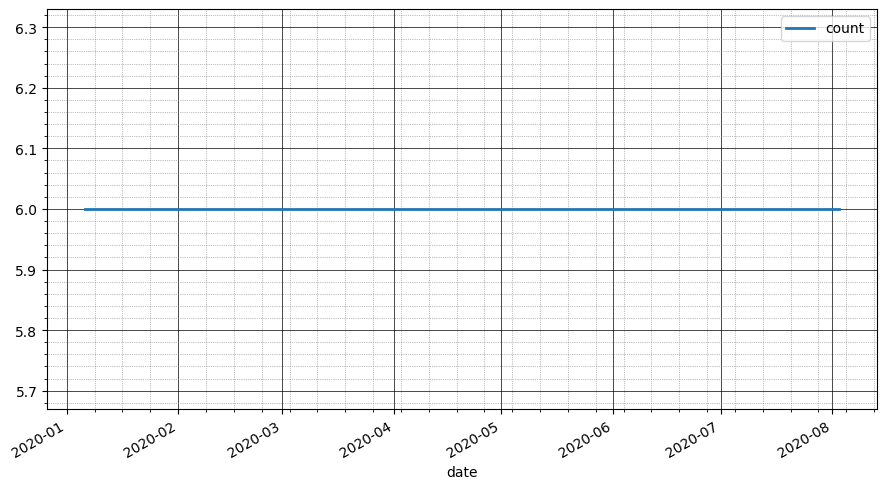

<Figure size 900x500 with 0 Axes>

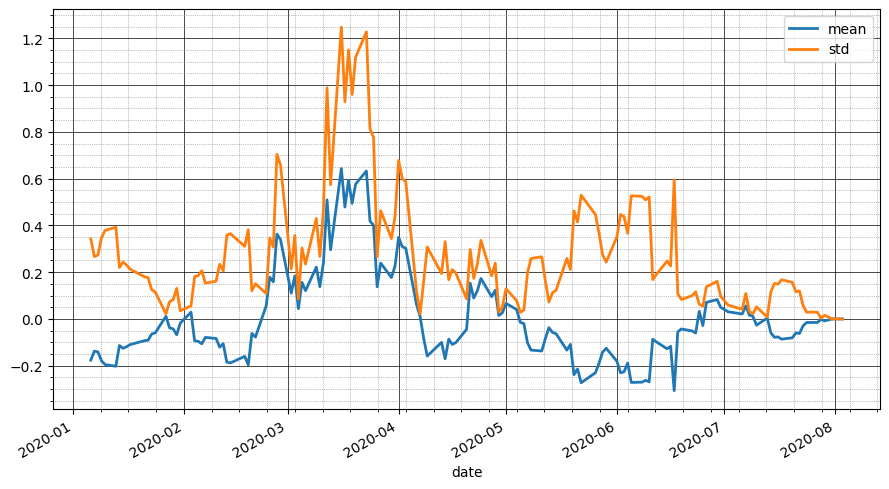

<Figure size 900x500 with 0 Axes>

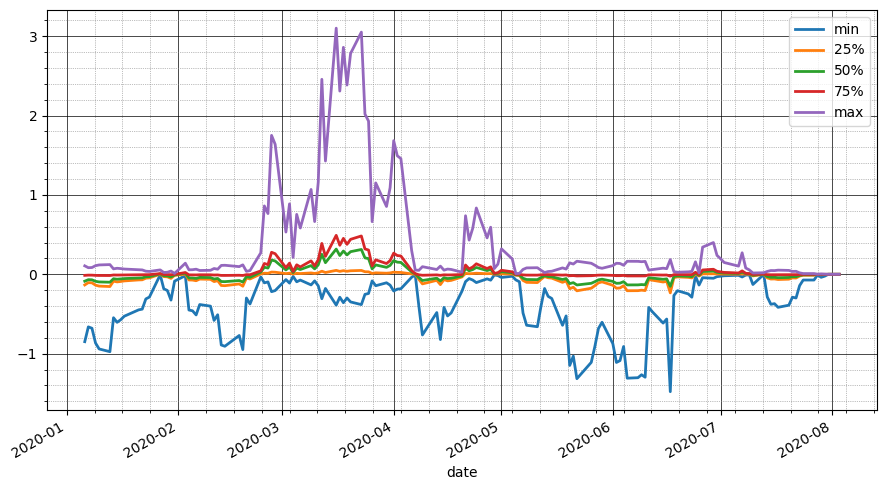

In [12]:
plot_desc_pfo_matrix(weights)

# Splitting the data

In [13]:
%%time

volume_smoother = pl.col('volume').rolling_mean(window_size=5).over(keys[1])

n_days_listed = pl.col('date_index') - pl.col('date_index').min().over(keys[1]) + 1

prices = (
    pl.scan_parquet('prices_yf.parquet')
    .filter(pl.col(keys[0]) >= start_date)
)

dates = (
    prices
    .select(pl.col('date').unique(maintain_order=True))
    .with_columns(date_index=pl.lit(1))
    .with_columns(pl.col('date_index').cum_sum() - 1)
)

prices = (
    prices
    .join(dates, on='date', how='left')
    .with_columns(n_days_listed=n_days_listed)
    .with_columns(volume_smoothed=volume_smoother)
    .collect()
)
prices.null_count()

CPU times: user 6.18 s, sys: 2.06 s, total: 8.24 s
Wall time: 1.11 s


date,symbol,price,volume,date_index,n_days_listed,volume_smoothed
u32,u32,u32,u32,u32,u32,u32
0,0,47,47,0,0,16472


In [14]:
formation_length = 100
trading_length = 50
sum_lengths = trading_length + formation_length

prices = (
    prices
    .with_columns(
        batch=pl.col('date_index') // sum_lengths,
        is_formation=pl.col('date_index') % sum_lengths < formation_length,
    )
    .filter(pl.col('batch') != pl.col('batch').max())
)
prices.tail()

date,symbol,price,volume,date_index,n_days_listed,volume_smoothed,batch,is_formation
date,str,f64,f64,i32,i32,f64,i32,bool
2023-11-06,"""ZURA""",4.63,645885.015965,5999,160,654952.001295,39,false
2023-11-06,"""ZVRA""",4.56,412679.994822,5999,2156,549397.996674,39,false
2023-11-06,"""ZVSA""",3.01,103655.369672,5999,436,804063.780026,39,false
2023-11-06,"""ZYME""",7.28,2.4424e6,5999,1643,3.3810e6,39,false
2023-11-06,"""ZYXI""",9.29,2.2649e6,5999,4960,3.1455e6,39,false


In [15]:
attrs = ['min', 'max', 'len']
(
    prices
    .group_by('batch')
    .agg(pl.col('date_index').n_unique())
    .group_by('date_index')
    .agg([getattr(pl.col('batch'), attr)().alias(attr) for attr in attrs])
)

date_index,min,max,len
u32,i32,i32,u32
150,0,39,40


In [16]:
attrs = ['min', 'max', 'len']
(
    prices
    .group_by('batch', 'is_formation')
    .agg(pl.col('date_index').n_unique())
    .group_by('is_formation')
    .agg([getattr(pl.col('date_index'), attr)().alias(attr) for attr in attrs])
)

is_formation,min,max,len
bool,u32,u32,u32
false,50,50,40
true,100,100,40


In [17]:
n_stocks = 100

volume_rank = pl.col('volume_smoothed').rank(method='ordinal', descending=True).over(keys[0])

is_first_formation_date = (
    pl.when(
        (pl.col('date') == pl.col('date').min().over('batch', 'is_formation'))
        & pl.col('is_formation'))
    .then(True)
    .otherwise(False)
)

at_first_formations_dates = (
    prices
    .filter(is_first_formation_date)
    .filter(pl.col('n_days_listed') >= formation_length)
    .filter(volume_rank <= n_stocks)
)
universe = (
    at_first_formations_dates
    .select(*keys, pl.col('is_formation').alias('is_in_universe'))
)
at_first_formations_dates.group_by('batch').len().describe()
# the first batch is lost because pl.col('n_days_listed') < formation_length

statistic,batch,len
str,f64,f64
"""count""",39.0,39.0
"""null_count""",0.0,0.0
"""mean""",20.0,100.0
"""std""",11.401754,0.0
"""min""",1.0,100.0
"""25%""",11.0,100.0
"""50%""",20.0,100.0
"""75%""",30.0,100.0
"""max""",39.0,100.0


In [18]:
universe = (
    prices
    .join(universe, on=keys, how='left')
    .with_columns(pl.col('is_in_universe').forward_fill().over(keys[1], 'batch'))
    .filter(pl.col('is_in_universe'))
)
universe.columns

['date',
 'symbol',
 'price',
 'volume',
 'date_index',
 'n_days_listed',
 'volume_smoothed',
 'batch',
 'is_formation',
 'is_in_universe']

In [19]:
descs = universe.group_by('batch', 'is_formation').len().drop('batch').to_pandas()
descs.groupby('is_formation').describe()

len                                                           
             count     mean  std      min      25%      50%      75%      max
is_formation                                                                 
False         39.0   5000.0  0.0   5000.0   5000.0   5000.0   5000.0   5000.0
True          39.0  10000.0  0.0  10000.0  10000.0  10000.0  10000.0  10000.0

In [20]:
universe.null_count()

date,symbol,price,volume,date_index,n_days_listed,volume_smoothed,batch,is_formation,is_in_universe
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


In [21]:
%%time
formation_length = 100
trading_length = 50
n_stocks = 100

test = get_universe(formation_length, trading_length, n_stocks)

CPU times: user 1.28 ms, sys: 627 µs, total: 1.91 ms
Wall time: 1.82 ms


In [22]:
%%time
test = test.collect()

CPU times: user 11.5 s, sys: 2.98 s, total: 14.5 s
Wall time: 2.77 s


In [23]:
cols = [*keys, 'price', 'volume', 'volume_smoothed', 'batch', 'is_formation']
assert test.select(cols).equals(universe.select(cols))

In [24]:
splits = get_splits(test)
for formation, trading in splits:
    pass

In [25]:
%%time
n_nulls, weights = fit_n_trade(formation, trading, seeds_all[0], t_max)

CPU times: user 81.5 ms, sys: 205 ms, total: 286 ms
Wall time: 1.92 s
